In [16]:
import re
import gc
import os
import time
import datetime
import collections
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from scipy.fftpack import fft
import matplotlib.pyplot as plt

from IPython.display import clear_output

import keras
from keras import optimizers
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dense, Input, Dropout, Flatten, Activation, Conv1D, LSTM
from keras.layers.advanced_activations import PReLU
from keras.initializers import Constant
from keras.initializers import he_normal, he_uniform
from keras.models import Model
from keras.optimizers import Adam, Nadam
from keras.callbacks import TensorBoard
from keras.regularizers import l2
from keras.models import Sequential
from keras.callbacks import LearningRateScheduler

from glob import glob

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.layers import Dense, SimpleRNN, LSTM, Bidirectional, TimeDistributed, Conv1D, ZeroPadding1D, GRU
from keras.layers import Lambda, Input, Dropout, Masking, BatchNormalization, Activation
from keras.models import Model

In [17]:
# seems to reduce the chance of gpu errors, also doesn't blindly allocate all vram 

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [4]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

def list_wavs_fname(dirpath, ext='wav'):
    fpaths = glob(os.path.join(dirpath, r'*/*' + ext))
    pat = r'.+\\(\w+)\\\w+\.wav$'
    labels = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            labels.append(r.group(1))
    pat = r'.+\\(\w+\.wav)$'
    fnames = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            fnames.append(r.group(1))
    return labels, fnames

def pad_audio(samples):
    if len(samples) >= L: return samples
    else: return np.pad(samples, pad_width=(L - len(samples), 0), mode='constant', constant_values=(0, 0))

def chop_audio(samples, L=16000, num=20):
    for i in range(num):
        beg = np.random.randint(0, len(samples) - L)
        yield samples[beg: beg + L]

def label_transform(labels):
    nlabels = []
    for label in labels:
        if label == '_background_noise_':
            nlabels.append('silence')
        elif label not in legal_labels:
            nlabels.append('unknown')
        else:
            nlabels.append(label)
    return pd.get_dummies(pd.Series(nlabels))

In [5]:
L = 16000
legal_labels = 'yes no up down left right on off stop go silence unknown'.split()

#src folders
root_path = r'.\\data'
out_path = r'.'
model_path = r'.'
train_data_path = os.path.join(root_path, 'input', 'train', 'audio')
test_data_path = os.path.join(root_path, 'input', 'test', 'audio')

In [37]:
labels, fnames = list_wavs_fname(train_data_path)
np.random.seed(0)

new_sample_rate = 16000
y = []
x = []
xu=[]
yu=[]
x_val = []
y_val = []
t0 = datetime.datetime.now()
i = 1

for label, fname in zip(labels, fnames):
    if label not in legal_labels and label != '_background_noise_':# and np.random.randint(10) > 0:
        continue
    if i%100 == 0:
        delta = datetime.datetime.now() - t0
        clear_output(wait=True)
        print('%.2f%% %.1f seconds left' % (i/647.27, delta.total_seconds()*(64727/i-1)))
    i+=1
    sample_rate, samples = wavfile.read(os.path.join(train_data_path, label, fname))
    samples = pad_audio(samples)
    if len(samples) > 16000:
        n_samples = chop_audio(samples)
    else: n_samples = [samples]
    for samples in n_samples:
        resampled = signal.resample(samples, int(new_sample_rate / sample_rate * samples.shape[0]))
        _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
        if fname[0] == '0' or fname[0] == '1' or label == '_background_noise_' and np.random.randint(5) == 0:
            y_val.append(label)
            x_val.append(specgram)
        else:
            y.append(label)
            x.append(specgram)
        
x_mean = np.array(x).mean()
x_std = np.array(x).std()

        
#for u in range(10):
for u in range(1):
    xu.append(x.copy())
    yu.append(y.copy())
    np.random.seed(0)
    for label, fname in zip(labels, fnames):
        if i%100 == 0:
            delta = datetime.datetime.now() - t0
            clear_output(wait=True)
            print('%.2f%% %.1f seconds left' % (i/647.27, delta.total_seconds()*(64727/i-1)))
        if label not in legal_labels and label != '_background_noise_' and np.random.randint(10) == u:
            i+=1
            sample_rate, samples = wavfile.read(os.path.join(train_data_path, label, fname))
            samples = pad_audio(samples)
            if len(samples) > 16000:
                n_samples = chop_audio(samples)
            else: n_samples = [samples]
            for samples in n_samples:
                resampled = signal.resample(samples, int(new_sample_rate / sample_rate * samples.shape[0]))
                _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
                if fname[0] == '0' or fname[0] == '1':
                    y_val.append(label)
                    x_val.append(specgram)
                else:
                    yu[u].append(label)
                    xu[u].append(specgram)

    xu[u] = np.array(xu[u])
    xu[u] = (xu[u] - x_mean) / x_std
    yu[u] = label_transform(yu[u])
    yu[u] = yu[u].values
    yu[u] = np.array(yu[u])

x_val = np.array(x_val)
x_val = (x_val - x_mean) / x_std
y_val = label_transform(y_val)
label_index = y_val.columns.values
y_val = y_val.values
y_val = np.array(y_val)

# x = np.array(x)
# y = label_transform(y)
# label_index = y.columns.values
# y = y.values
# y = np.array(y)
# x_mean = x.mean()
# x_std = x.std()
# x = (x - x_mean) / x_std
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
del x, y
gc.collect()

42.80% 44.3 seconds left


22

In [68]:
collections.Counter(label_index[np.argmax(y_val, axis=1)])

Counter({'down': 257,
         'go': 280,
         'left': 251,
         'no': 272,
         'off': 241,
         'on': 255,
         'right': 238,
         'stop': 256,
         'up': 269,
         'yes': 272,
         'silence': 32,
         'unknown': 462})

In [22]:
np.random.seed(0)
def little_boy():
    i = Input(shape=(99, 161))
    x = Dropout(0.2)(i)
    x = Conv1D(filters=256, kernel_size=19, strides=8, kernel_regularizer=l2(1e-4), kernel_initializer=he_uniform())(x)
    x = PReLU(alpha_initializer=Constant(value=0.25))(x)
    x = BatchNormalization()(x)
        
    x = LSTM(256, unroll=True,
             dropout=0.4, recurrent_dropout=0.5, 
             kernel_regularizer=l2(1e-3), recurrent_regularizer=l2(1e-5), bias_regularizer=l2(1e-5))(x)
    x = Dropout(0.5)(x)
    
    x = Dense(256, kernel_regularizer=l2(1e-2), kernel_initializer=he_uniform())(x)
    x = PReLU(alpha_initializer=Constant(value=0.25))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    o = Dense(12, activation='softmax')(x)
    
    return Model(inputs=i, outputs=o)

model = little_boy()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 99, 161)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 99, 161)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 256)           783360    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 11, 256)           2816      
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 256)           1024      
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0   

In [26]:
models = []
for u in range(10):
    models.append(little_boy())
    
histories = []    
opt = Nadam(lr=1e-3, epsilon=1e-4)
def step_scheduler(epoch, lr):
    return 2e-3 - 1e-5*epoch

for u in range(10):
    models[u].compile(
        loss='categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy'])
    histories.append(models[u].fit(
        xu[u], yu[u],
        workers=2,
        batch_size=512, epochs=200,
        #validation_data=(x_test, y_test),
        verbose=0,
        callbacks=[LearningRateScheduler(step_scheduler, verbose=0)]))
    clear_output(wait=True)
    print(str(u+1)+'/10')

10/10


In [ ]:
opt = Nadam(lr=1e-3, epsilon=1e-4)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

def step_scheduler(epoch, lr):
    return 2e-3 - 1e-5*epoch

history = model.fit(x_train, y_train,
                    workers=2,
                    batch_size=512, epochs=200,
                    validation_data=(x_test, y_test),
                    verbose=2,
                    callbacks=[LearningRateScheduler(step_scheduler, verbose=0)])

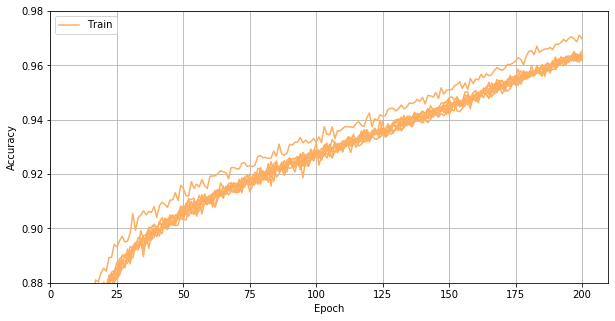

In [33]:
f = plt.figure(figsize=(10,5))

x = range(1, 201)
for u in range(10):
    y1 = histories[u].history['accuracy']# + history2.history['accuracy']
    #y2 = histories[u].history['val_accuracy']# + history2.history['val_accuracy']

    #xs = np.linspace(1, 400, 1000)
    #y1s = UnivariateSpline(x, y1, s=0.002)(xs)
    #y2s = UnivariateSpline(x, y2, s=0.03)(xs)

    #plt.plot(xs, y1s, color='#377eb8', linewidth=2.0)
    #plt.plot(xs, y2s, color='#4daf4a', linewidth=2.0)
    #plt.plot(x, acc, color='#abd9e9')
    #plt.plot(x, val, color='#2c7bb6')
    plt.plot(x, y1, color='#fdae61')
    #plt.plot(x, y2, color='#d7191c')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.ylim(.88, .98)
plt.xlim(0)
plt.grid()
plt.show()

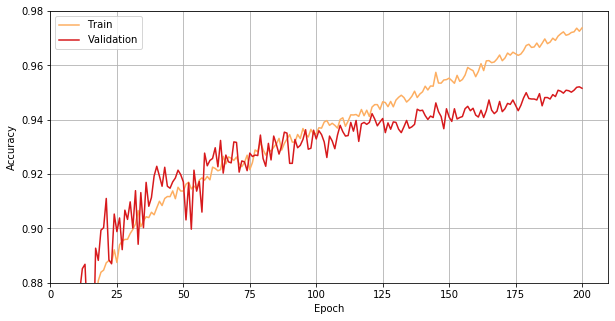

In [20]:
f = plt.figure(figsize=(10,5))

x = range(1, 201)
y1 = history.history['accuracy']# + history2.history['accuracy']
y2 = history.history['val_accuracy']# + history2.history['val_accuracy']

#xs = np.linspace(1, 400, 1000)
#y1s = UnivariateSpline(x, y1, s=0.002)(xs)
#y2s = UnivariateSpline(x, y2, s=0.03)(xs)

#plt.plot(xs, y1s, color='#377eb8', linewidth=2.0)
#plt.plot(xs, y2s, color='#4daf4a', linewidth=2.0)
#plt.plot(x, acc, color='#abd9e9')
#plt.plot(x, val, color='#2c7bb6')
plt.plot(x, y1, color='#fdae61')
plt.plot(x, y2, color='#d7191c')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(.88, .98)
plt.xlim(0)
plt.grid()
plt.show()

In [91]:
from keras.layers.advanced_activations import ELU

def big_boy():
    input_data = Input(shape=(99, 161))

    x = Conv1D(filters=256, kernel_size=9, strides=3, kernel_regularizer=l2(1e-4), kernel_initializer=he_uniform())(input_data)
    #x = PReLU(alpha_initializer=Constant(value=0.25))(x)
    x = ELU(alpha=1.0)(x)
    x = BatchNormalization()(x)
        
    x = LSTM(256, unroll=True,
             dropout=0.4, recurrent_dropout=0.5,
             kernel_regularizer=l2(1e-3), recurrent_regularizer=l2(1e-5), bias_regularizer=l2(1e-5))(x)
    x = Dropout(0.5)(x)

    x = Dense(units=256, kernel_regularizer=l2(1e-2), kernel_initializer=he_uniform())(x)
    #x = PReLU(alpha_initializer=Constant(value=0.25))(x)
    x = ELU(alpha=1.0)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    y_pred = Dense(units=12, activation='softmax')(x)
    
    return Model(inputs=input_data, outputs=y_pred)

model = big_boy()
model.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 99, 161)           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 30, 256)           494848    
_________________________________________________________________
elu_26 (ELU)                 (None, 30, 256)           0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 30, 256)           1024      
_________________________________________________________________
lstm_19 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_37 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 256)               657

In [92]:
opt = Nadam(lr=.01, epsilon=1e-4)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

def step_scheduler(epoch, lr):
    if epoch < 2:
        return lr/2
    return 2e-3 - 1e-5*epoch


history = model.fit(xu[0], yu[0],
                    batch_size=256, epochs=200,
                    validation_data=(x_val, y_val),
                    #verbose=2,
                    callbacks=[LearningRateScheduler(step_scheduler, verbose=0)])

Train on 24789 samples, validate on 3085 samples
Epoch 1/200
24789/24789 [==============================] - 8s 335us/step - loss: 4.5377 - accuracy: 0.2788 - val_loss: 2.3885 - val_accuracy: 0.3679
Epoch 2/200
24789/24789 [==============================] - 6s 229us/step - loss: 1.6626 - accuracy: 0.6032 - val_loss: 1.3864 - val_accuracy: 0.6891
Epoch 3/200
24789/24789 [==============================] - 6s 228us/step - loss: 1.2102 - accuracy: 0.7286 - val_loss: 0.9754 - val_accuracy: 0.8298
Epoch 4/200
24789/24789 [==============================] - 6s 228us/step - loss: 1.0313 - accuracy: 0.7816 - val_loss: 0.7901 - val_accuracy: 0.8658
Epoch 5/200
24789/24789 [==============================] - 6s 228us/step - loss: 0.9249 - accuracy: 0.8164 - val_loss: 0.6932 - val_accuracy: 0.8898
Epoch 6/200
24789/24789 [==============================] - 6s 228us/step - loss: 0.8585 - accuracy: 0.8328 - val_loss: 0.6963 - val_accuracy: 0.8797
Epoch 7/200
24789/24789 [==============================] 

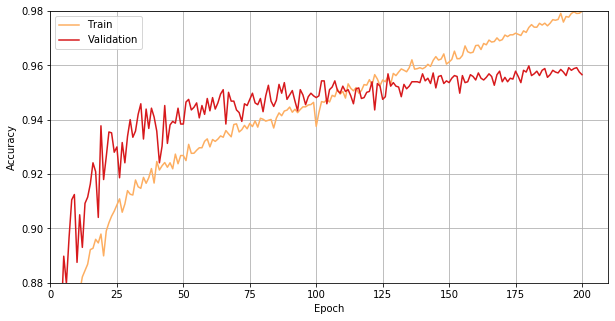

In [93]:
f = plt.figure(figsize=(10,5))

x = range(1, 201)
y1 = history.history['accuracy']# + history2.history['accuracy']
y2 = history.history['val_accuracy']# + history2.history['val_accuracy']

#xs = np.linspace(1, 400, 1000)
#y1s = UnivariateSpline(x, y1, s=0.002)(xs)
#y2s = UnivariateSpline(x, y2, s=0.03)(xs)

#plt.plot(xs, y1s, color='#377eb8', linewidth=2.0)
#plt.plot(xs, y2s, color='#4daf4a', linewidth=2.0)
#plt.plot(x, acc, color='#abd9e9')
#plt.plot(x, val, color='#2c7bb6')
plt.plot(x, y1, color='#fdae61')
plt.plot(x, y2, color='#d7191c')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(.88, .98)
plt.xlim(0)
plt.grid()
plt.show()

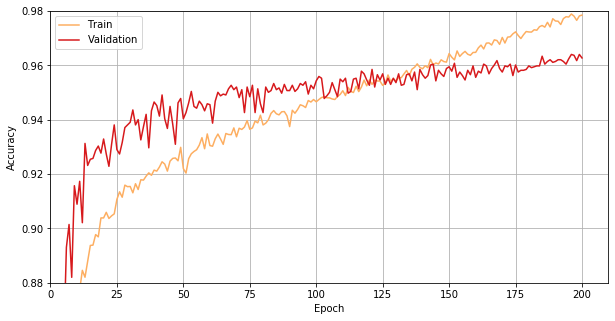

In [90]:
f = plt.figure(figsize=(10,5))

x = range(1, 201)
y1 = history.history['accuracy']# + history2.history['accuracy']
y2 = history.history['val_accuracy']# + history2.history['val_accuracy']

#xs = np.linspace(1, 400, 1000)
#y1s = UnivariateSpline(x, y1, s=0.002)(xs)
#y2s = UnivariateSpline(x, y2, s=0.03)(xs)

#plt.plot(xs, y1s, color='#377eb8', linewidth=2.0)
#plt.plot(xs, y2s, color='#4daf4a', linewidth=2.0)
#plt.plot(x, acc, color='#abd9e9')
#plt.plot(x, val, color='#2c7bb6')
plt.plot(x, y1, color='#fdae61')
plt.plot(x, y2, color='#d7191c')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(.88, .98)
plt.xlim(0)
plt.grid()
plt.show()

In [6]:
collections.Counter(label_index[np.argmax(y, axis=1)])

Counter({'down': 2359,
         'go': 2372,
         'left': 2353,
         'no': 2375,
         'off': 2357,
         'on': 2367,
         'right': 2367,
         'stop': 2380,
         'up': 2375,
         'yes': 2377,
         'silence': 120})

In [42]:
def test_data_generator(batch):
    fpaths = glob(os.path.join(test_data_path, '*wav'))
    i = 0
    for path in fpaths:
        if i == 0:
            imgs = []
            fnames = []
        i += 1
        rate, samples = wavfile.read(path)
        samples = pad_audio(samples)
        resampled = signal.resample(samples, int(new_sample_rate / rate * samples.shape[0]))
        _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
        imgs.append(specgram)
        fnames.append(path.split('\\')[-1])
        if i == batch:
            i = 0
            yield fnames, (np.array(imgs) - x_mean) / x_std
    yield fnames, (np.array(imgs) - x_mean) / x_std
    raise StopIteration()

In [43]:
gc.collect()

index = []
results = []
t0 = datetime.datetime.now()
i = 1
b = 128

for fnames, imgs in test_data_generator(b):
#     pred = np.sqrt(models[9].predict(imgs))
#     for u in range(9):
#         pred = pred + np.sqrt(models[u].predict(imgs))
    pred = model.predict(imgs)  
    pred = np.argmax(pred, axis=1)
    pred = [label_index[p] for p in pred]
    index.extend(fnames)
    results.extend(pred)
    delta = datetime.datetime.now() - t0
    clear_output(wait=True)
    print('%.2f%% %.1f seconds left' % (b*i/1585.38, delta.total_seconds()*(158538/b/i-1)))
    i+=1

100.03% -0.3 seconds left


RuntimeError: generator raised StopIteration

In [44]:
df = pd.DataFrame(columns=['fname', 'label'])
df['fname'] = index
df['label'] = results
df.to_csv(os.path.join(out_path, 'submission.csv'), index=False)

In [45]:
df['label'].value_counts()

unknown    74886
left       11458
right       9199
on          8390
no          7617
go          7486
off         7289
up          6936
stop        6583
silence     6567
down        6126
yes         6001
Name: label, dtype: int64